In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection

In [27]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [28]:
class Leaf:
    def __init__(self, labels):
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        if len(self.labels) == 0:
            return 0
        class_counts = np.bincount(self.labels)
        return np.argmax(class_counts)

In [30]:
class DecisionTreeClassifier:
    def __init__(self, min_leaf=5):
        self.min_leaf = min_leaf
        self.tree = None

    def gini(self, labels):
        if len(labels) == 0:
            return 0
        _, counts = np.unique(labels, return_counts=True)
        p_k = counts / len(labels)
        return np.sum(p_k*(1-p_k))
    
    def quality(self, left_labels, right_labels, current_gini):
        n_left = len(left_labels)
        n_right = len(right_labels)
        n_total = n_left + n_right
        
        if n_total == 0:
            return 0
        
        gini_left = self.gini(left_labels)
        gini_right = self.gini(right_labels)
        weighted_gini = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right
        
        return current_gini - weighted_gini
    
    def split(self, data, labels, index, t):
        mask = data[:, index] <= t
        return (
            data[mask], 
            data[~mask], 
            labels[mask], 
            labels[~mask]
        )
    
    def find_best_split(self, data, labels):
        current_gini = self.gini(labels)
        best_gain = 0
        best_t = None
        best_index = None
        
        n_features = data.shape[1]
        
        for index in range(n_features):
            values = np.unique(data[:, index])
            values.sort()
            
            for t in values[:-1]:
                _, _, true_labels, false_labels = self.split(data, labels, index, t)
                
                if len(true_labels) < self.min_leaf or len(false_labels) < self.min_leaf:
                    continue
                
                gain = self.quality(true_labels, false_labels, current_gini)
                
                if gain > best_gain:
                    best_gain = gain
                    best_t = t
                    best_index = index
        
        if best_gain == 0:
            return None, None, None
        
        return best_gain, best_t, best_index
    
    def build_tree(self, data, labels):
        gain, t, index = self.find_best_split(data, labels)
        
        if gain is None:
            return Leaf(labels)
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)
        
        return Node(index, t, true_branch, false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def classify_object(self, obj, node):
        if isinstance(node, Leaf):
            return node.prediction
        
        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def predict(self, data):
        return np.array([self.classify_object(obj, self.tree) for obj in data])
    
    def print_tree_recursive(self, node, spacing=""):
        if isinstance(node, Leaf):
            print(f"{spacing}Лист: предсказание={node.prediction}, объектов={len(node.labels)}")
            return
        
        print(f"{spacing}Узел: признак[{node.index}] <= {node.t:.2f}")
        
        print(f"{spacing}--> True:")
        self.print_tree_recursive(node.true_branch, spacing + "  ")
        
        print(f"{spacing}--> False:")
        self.print_tree_recursive(node.false_branch, spacing + "  ")
    
    def print_tree(self):
        print("Структура дерева:")
        self.print_tree_recursive(self.tree)

In [31]:
classification_data, classification_labels = datasets.make_classification(
    n_features=2, n_informative=2, n_classes=2, n_redundant=0,
    n_clusters_per_class=1, random_state=5
)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels,
    test_size=0.3, random_state=1
)

clf = DecisionTreeClassifier(min_leaf=5)
clf.fit(train_data, train_labels)

clf.print_tree()

train_answers = clf.predict(train_data)
test_answers = clf.predict(test_data)

def accuracy_metric(actual, predicted):
    return np.mean(actual == predicted) * 100

train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f"\nTrain accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Структура дерева:
Узел: признак[0] <= 0.16
--> True:
  Узел: признак[1] <= -1.52
  --> True:
    Узел: признак[0] <= -0.95
    --> True:
      Лист: предсказание=0, объектов=6
    --> False:
      Лист: предсказание=1, объектов=6
  --> False:
    Лист: предсказание=0, объектов=28
--> False:
  Лист: предсказание=1, объектов=30

Train accuracy: 98.57%
Test accuracy: 100.00%


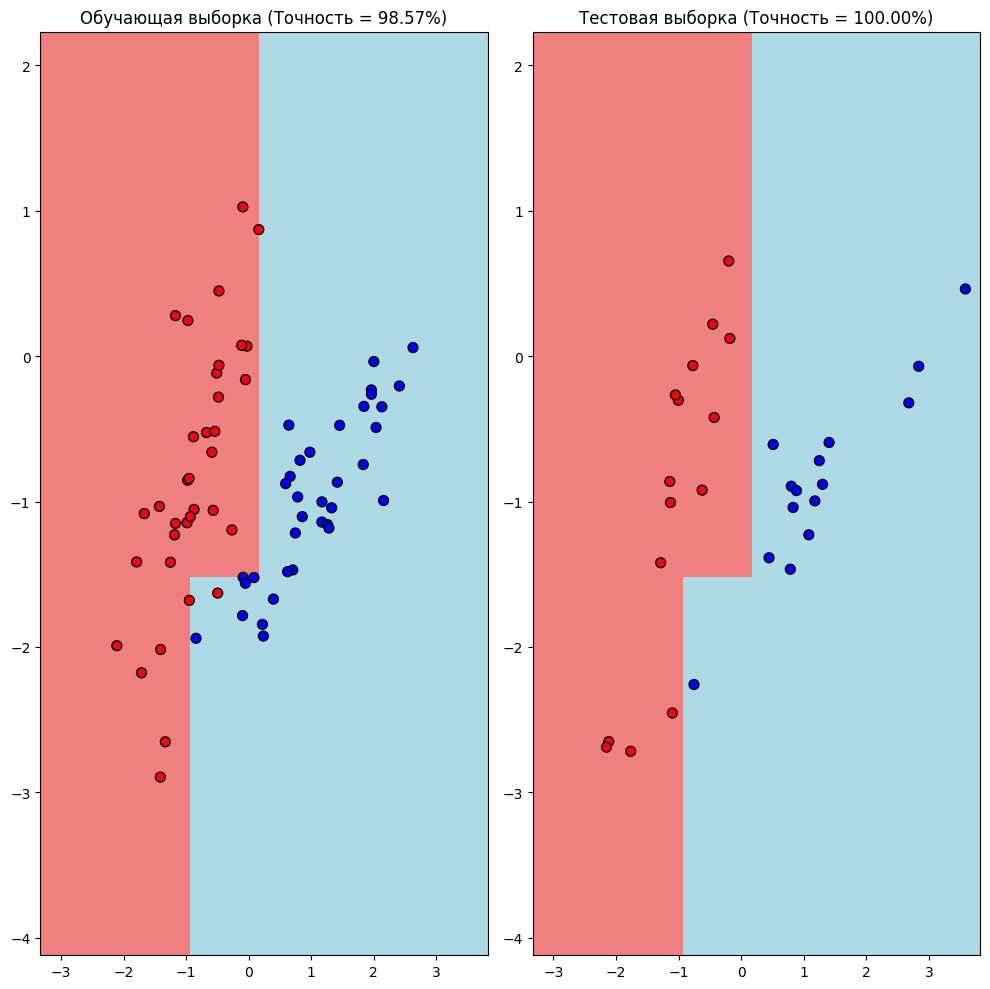

In [34]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step),
                      np.arange(y_min, y_max, step))

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors, edgecolor='k', s=50)
plt.title(f'Обучающая выборка (Точность = {train_accuracy:.2f}%)')

plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors, edgecolor='k', s=50)
plt.title(f'Тестовая выборка (Точность = {test_accuracy:.2f}%)')

plt.tight_layout()
plt.show()

In [22]:
import random

class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch 


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
    
    def predict(self):
        if len(self.labels) == 0:
            return 0
        class_counts = np.bincount(self.labels)
        return np.argmax(class_counts)

In [23]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples_leaf=1):
        self.n_trees = n_trees
        self.min_samples_leaf = min_samples_leaf
        self.forest = []
        
    def get_bootstrap(self, data, labels, N):
        n_samples = data.shape[0]
        bootstrap = []
        
        for i in range(N):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            b_data = data[indices]
            b_labels = labels[indices]
            bootstrap.append((b_data, b_labels))
            
        return bootstrap
    
    def get_subsample(self, len_sample):
        sample_indexes = [i for i in range(len_sample)]
        
        len_subsample = int(np.sqrt(len_sample))
        subsample = []
        
        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            if sample_indexes:
                subsample.append(sample_indexes.pop())
                
        return subsample
    
    def gini(self, labels):
        if len(labels) == 0:
            return 0
        _, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        return 1 - np.sum(probabilities ** 2)
    
    def quality(self, left_labels, right_labels, current_gini):
        n_left = len(left_labels)
        n_right = len(right_labels)
        n_total = n_left + n_right
        
        if n_total == 0:
            return 0
        
        gini_left = self.gini(left_labels)
        gini_right = self.gini(right_labels)
        weighted_gini = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right
        
        return current_gini - weighted_gini
    
    def split(self, data, labels, index, t):
        mask = data[:, index] <= t
        return (
            data[mask],
            data[~mask],
            labels[mask],
            labels[~mask]
        )
    
    def find_best_split(self, data, labels):
        current_gini = self.gini(labels)
        best_gain = 0
        best_t = None
        best_index = None
        
        n_features = data.shape[1]
        feature_indices = self.get_subsample(n_features)
        
        for index in feature_indices:
            values = np.unique(data[:, index])
            if len(values) < 2:
                continue
                
            thresholds = (values[:-1] + values[1:]) / 2
            
            for t in thresholds:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                
                if len(true_labels) < self.min_samples_leaf or len(false_labels) < self.min_samples_leaf:
                    continue
                
                gain = self.quality(true_labels, false_labels, current_gini)
                
                if gain > best_gain:
                    best_gain = gain
                    best_t = t
                    best_index = index
        
        return best_gain, best_t, best_index
    
    def build_tree(self, data, labels):
        gain, t, index = self.find_best_split(data, labels)
        
        if gain == 0 or gain is None:
            return Leaf(data, labels)
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)
        
        return Node(index, t, true_branch, false_branch)
    
    def fit(self, data, labels):
        bootstrap = self.get_bootstrap(data, labels, self.n_trees)
        self.forest = []
        
        for b_data, b_labels in bootstrap:
            tree = self.build_tree(b_data, b_labels)
            self.forest.append(tree)
        
        return self
    
    def classify_object(self, obj, node):
        if isinstance(node, Leaf):
            return node.prediction
        
        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def predict_tree(self, data, tree):
        classes = []
        for obj in data:
            classes.append(self.classify_object(obj, tree))
        return classes
    
    def predict(self, data):
        all_predictions = []
        for tree in self.forest:
            tree_pred = self.predict_tree(data, tree)
            all_predictions.append(tree_pred)
        
        all_predictions = np.array(all_predictions).T

        voted_predictions = []
        for obj_preds in all_predictions:
            values, counts = np.unique(obj_preds, return_counts=True)
            voted_predictions.append(values[np.argmax(counts)])
        
        return voted_predictions



def random_forest(data, labels, n_trees):
    rf = RandomForest(n_trees=n_trees)
    rf.fit(data, labels)
    return rf


def tree_vote(forest, data):
    return forest.predict(data)


def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0




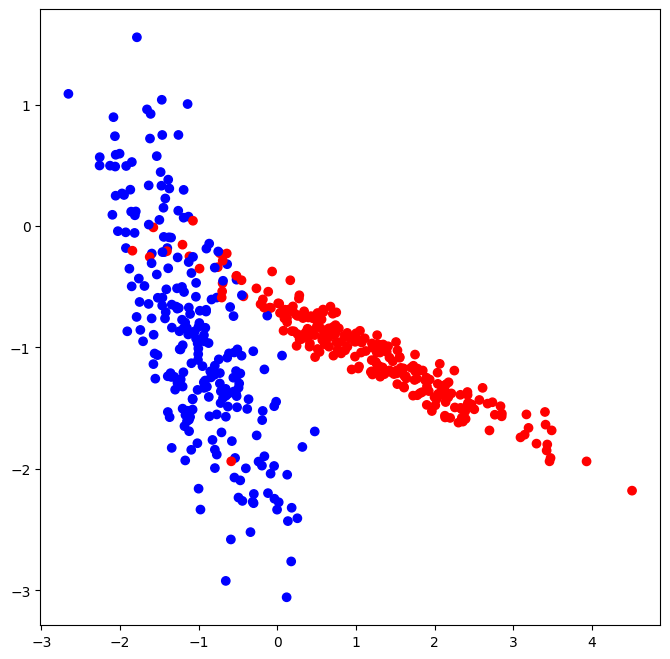

Точность случайного леса из 1 деревьев на обучающей выборке: 97.714%
Точность случайного леса из 1 деревьев на тестовой выборке: 91.333%
--------------------------------------------------
Точность случайного леса из 5 деревьев на обучающей выборке: 99.714%
Точность случайного леса из 5 деревьев на тестовой выборке: 93.333%
--------------------------------------------------
Точность случайного леса из 10 деревьев на обучающей выборке: 99.714%
Точность случайного леса из 10 деревьев на тестовой выборке: 92.667%
--------------------------------------------------
Точность случайного леса из 20 деревьев на обучающей выборке: 100.000%
Точность случайного леса из 20 деревьев на тестовой выборке: 93.333%
--------------------------------------------------
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000%
Точность случайного леса из 50 деревьев на тестовой выборке: 93.333%
--------------------------------------------------


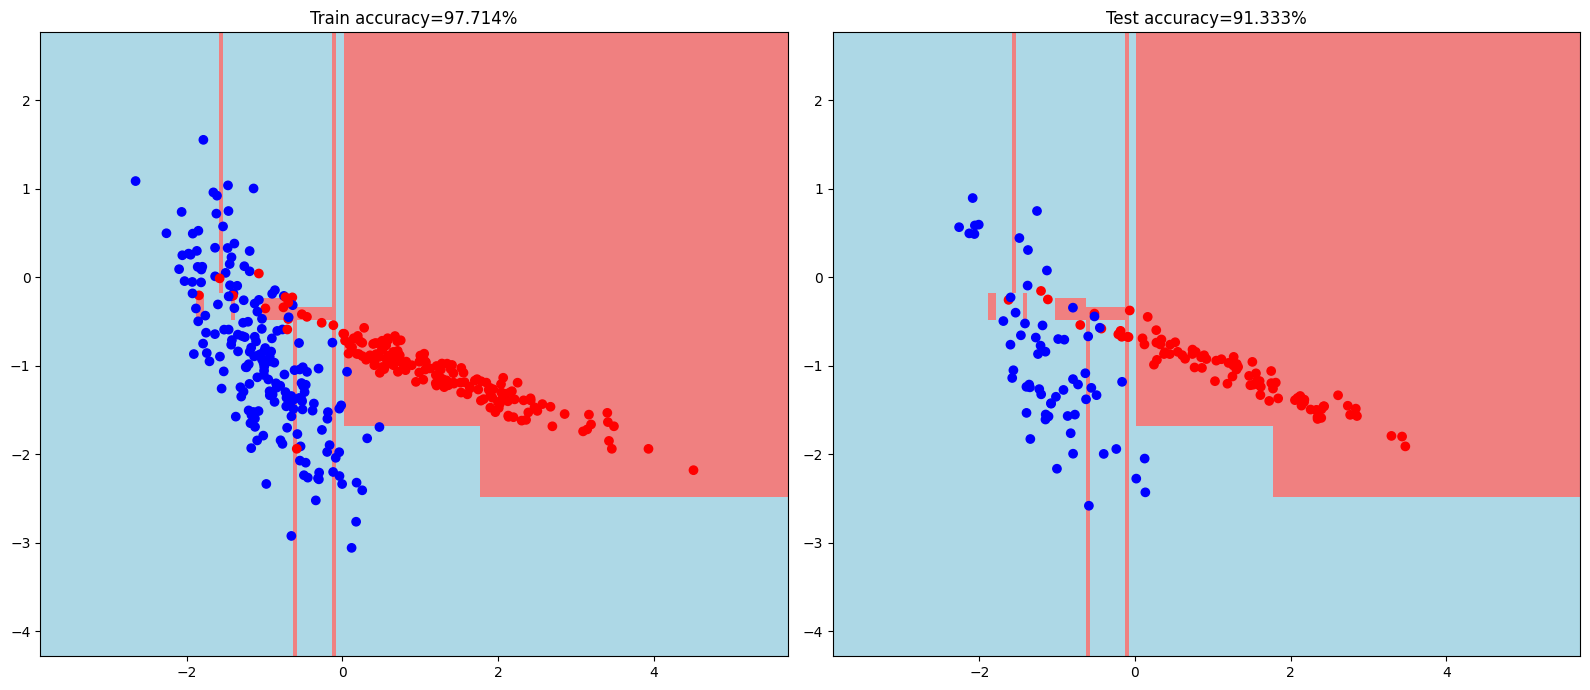

In [26]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2, 
    n_informative=2,
    n_classes=2, 
    n_redundant=0,
    n_clusters_per_class=1, 
    random_state=23
)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(classification_data[:, 0], classification_data[:, 1],
            c=classification_labels, cmap=colors)
plt.show()

random.seed(42)

# Разделение данных
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data,
    classification_labels,
    test_size=0.3,
    random_state=1
)

forests = []
for n_trees in [1, 5, 10, 20, 50]:
    my_forest = random_forest(train_data, train_labels, n_trees)
    forests.append((n_trees, my_forest))
    
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}%')
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}%')
    print('-' * 50)

n_trees, my_forest = forests[0]

train_answers = tree_vote(my_forest, train_data)
test_answers = tree_vote(my_forest, test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)


def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), 
                       np.arange(y_min, y_max, step))

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
plt.title(f'Train accuracy={train_accuracy:.3f}%')

plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
plt.title(f'Test accuracy={test_accuracy:.3f}%')

plt.tight_layout()
plt.show()